In [73]:
import os
from flask import Flask, request, jsonify
from typing import Annotated, Literal , List
from langchain_openai import ChatOpenAI
from langchain.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from pydantic import BaseModel, Field , field_validator, ValidationInfo
from langchain_core.tools import tool
from langgraph.prebuilt import create_react_agent
from langgraph.checkpoint.memory import MemorySaver
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.types import Command, interrupt
from langgraph.graph.message import AnyMessage
from API.booking import BookingAPI
from API.geoCoding import GeoCodingAPI
from API.getKey import OAuthClient
from API.getQuotes import QuotesAPI
from API.is_Airport import IsAirport

from langgraph.graph import StateGraph, MessagesState, START, END

from quotes import Quote

llm = ChatOpenAI(temperature=0.2, model="gpt-4o-mini")
jupiterAPI = os.getenv('JUPITER_API')
quoteAPI = str(jupiterAPI) + "/demand/v1/quotes"
bookingsAPI  = str(jupiterAPI) + '/demand/v1/bookings'

class BookingCarDetails(BaseModel):
    """Details for the bookings car details"""
    name: str = Field(
        ...,
        description="The name of the person booking the ride. Do not autofill if not provided",
    )
    number_phone: str = Field(
        ...,
        description="The phone number of the user. Do not autofill if not provided",
    )
    pick_up_location: str = Field(
        ...,
        description="The location where the user will be picked up. This can be a full address or a specific location name. Do not autofill if not provided",
    )
    destination_location: str = Field(
        ...,
        description="The destination location for the ride. This can be a full address or a specific location name. Do not autofill if not provided"
    )
    pick_up_time: str = Field(
        ...,
        description="The time the user intends to be picked up. No format keeps the text related to time. Do not autofill if not provided"
    )
    @field_validator('pick_up_location')
    @classmethod
    def validate_pickup(cls, value:str):
        geoCodingAPI = GeoCodingAPI()
        if value == '':
            return ''
        else :
            geoCoding_pickup = geoCodingAPI.get_geocoding(value)
            if geoCoding_pickup["status"] == "OK" :
                return geoCoding_pickup['results'][0]['formatted_address']
            else:
                raise ValueError(f"Invalid pick-up location: {value}")
    @field_validator('destination_location')
    @classmethod
    def validate_destination(cls, value : str, info: ValidationInfo):
        geoCodingAPI = GeoCodingAPI()
        
        # print (geoCoding_destination['results'][0]['formatted_address'])
        if value == '':
            return ''
        else :
            geoCoding_destination = geoCodingAPI.get_geocoding(value)
            if geoCoding_destination["status"] == "OK":
                if geoCoding_destination['results'][0]['formatted_address'] == info.data['pick_up_location']:
                    raise ValueError(f"Invalid destination location: {value}")
                else:
                    return geoCoding_destination['results'][0]['formatted_address']
            else:
            
                raise ValueError(f"Invalid destination location: {value}")

class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]
    quote_id: str
    booking_info: BookingCarDetails 
    slot_empty: list
# state = State(booking_info= BookingCarDetails(
#         name="", number_phone="", pick_up_location="", destination_location="", pick_up_time=""
#     )) 
def check_what_is_empty(user_personal_details):
    ask_for = []
    # Check if fields are empty
    for field, value in user_personal_details.model_dump().items():
        if value in [None, "", 0]:  # Add other 'empty' conditions if needed
            # print(f"Field '{field}' is empty.")
            ask_for.append(field)
    return ask_for


def add_non_empty_details(current_details: BookingCarDetails, new_details: BookingCarDetails):
    non_empty_details = {k: v for k, v in new_details.model_dump().items() if v not in [None, ""]}
    updated_details = current_details.model_copy(update=non_empty_details)
    return updated_details
def update_details(current_details: BookingCarDetails, new_details: BookingCarDetails , field : str):
    # non_empty_details = {k: v for k, v in new_details.model_dump().items() if v not in [None, ""]}
    updated_details = current_details.model_copy(update=field)
    return updated_details

def ask_for_info(ask_list: list):
    first_prompt = ChatPromptTemplate.from_template(
        """Ask one question at a time, even if you don't get all the info. Don't list the questions or greet the user. 
        Explain you're gathering info to help.
        ### ask_for list: {ask_for}"""
    )

    info_gathering_chain = first_prompt | llm | StrOutputParser()
    ai_chat = info_gathering_chain.invoke({"ask_for": ask_list})
    return ai_chat
def filter_response(text_input, user_details : BookingCarDetails ):
    chain = llm.with_structured_output(BookingCarDetails)
    res = chain.invoke(text_input)
    # add filtered info to the
    user_details = add_non_empty_details(user_details,res)
    ask_for = check_what_is_empty(user_details)
    return user_details, ask_for
def ask_confirm_info(booking_details: BookingCarDetails):
    # booking_details.
    message = (
        f"Please confirm your ride details:\n"
        f"- Pickup Location: {booking_details.pick_up_location}\n"
        f"- Destination: {booking_details.destination_location}\n"
        f"- Pickup Time: {booking_details.pick_up_time}\n"
        f"- Name: {booking_details.name}\n"
        f"- Contact Number: {booking_details.number_phone}\n"
    )
    print(message)
def call_model (state):
    messages = state["messages"]
    response = llm.invoke(messages)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}
@tool
def get_booking_details(state : MessagesState):
    """ Call function to get the details for a booking from user"""
    # state = State(booking_info=BookingCarDetails(name="", number_phone="", pick_up_location="", destination_location="", pick_up_time=""))
    chain = llm.with_structured_output(BookingCarDetails)
    response = chain.invoke(state["messages"][-1].content)
    booking_details = BookingCarDetails(name="", number_phone="", pick_up_location="", destination_location="", pick_up_time="")
    user_details = add_non_empty_details(booking_details, response)
    ask_for = check_what_is_empty(user_details)
    while ask_for:  
        ai_response = ask_for_info(ask_for)
        print(ai_response)
        # print(ai_response)
        text_input = interrupt(ai_response)
        print("hi" + text_input)
        user_details, ask_for = filter_response(text_input, user_details)
        return {"human_input": text_input}
    
    return user_details
@tool
def get_quotes(booking_details : BookingCarDetails):
    """Call function to fetches quotes for car bookings based on the provided booking details."""
    quotesAPI = QuotesAPI(os.getenv("JUPITER_API") + "/demand/v1/quotes")
    geoCodingAPI = GeoCodingAPI()
    # geoCoding_destination =
    geoCoding_pickup =  geoCodingAPI.get_geocoding(booking_details.pick_up_location)
    geoCoding_destination = geoCodingAPI.get_geocoding(booking_details.destination_location)
    # input_datetime = datetime.fromisoformat(pick_up_time)
    pickup_datetime = "2025-01-23T09:24:10.000Z"
    
    pickup_coords = { "latitude": float(geoCoding_pickup['results'][0]['geometry']['location']['lat']),"longitude": float(geoCoding_pickup['results'][0]['geometry']['location']['lng']),}
    destination_coords = { "latitude": float(geoCoding_destination['results'][0]['geometry']['location']['lat']),"longitude": float(geoCoding_destination['results'][0]['geometry']['location']['lng']),}
    quotes_data = quotesAPI.get_quotes(pickup_datetime, pickup_coords, destination_coords)
    quotes = []
    for item in quotes_data:
        quote = Quote(
        quote_id=item['quoteId'],
        expires_at=item['expiresAt'],
        vehicle_type=item['vehicleType'],
        price_value=item['price']['value'],
        price_currency=item['price']['currency'] if 'currency' in item['price'] and item['price']['currency'] is not None else 'CAD',
        luggage=item['luggage'],
        passengers=item['passengers'],
        provider_name=item['provider']['name'],
        provider_phone=item['provider']['phone']
        )
        quotes.append(quote)

    for quote in quotes:
        print({
            "title": f"{quote.vehicle_type} - {quote.price_value} {quote.price_currency}",
            "payload": f"{quote.quote_id}"
        })
    return "15$"
# @tool
# def ask_confirm(booking_details : BookingCarDetails):
#     """Ask the user again to confirm the booking details. """
#     message = (
#         f"Please confirm your ride details:\n"
#         f"- Pickup Location: {booking_details.pick_up_location}\n"
#         f"- Destination: {booking_details.destination_location}\n"
#         f"- Pickup Time: {booking_details.pick_up_time}\n"
#         f"- Name: {booking_details.name}\n"
#         f"- Contact Number: {booking_details.number_phone}\n"
#     )
#     print(message)
#     user_input = input()
#     return "User :" + user_input
@tool
def change_info(fields : List[str], booking_details : BookingCarDetails):
    """Change the booking details field """
    for field in fields:
        ai_response = ask_for_info([field])
        print(ai_response)
        text_input = input()
        chain = llm.with_structured_output(BookingCarDetails)
        response =chain.invoke(text_input)
        user_details = add_non_empty_details(booking_details,response)
    return user_details 
@tool
def accept_booking(quote_Id: str ,booking_details : BookingCarDetails ):
    """Call function to accept booking with quote_ID."""
    bookingAPI = BookingAPI(bookingsAPI)
    # quote_id = tracker.get_slot("quoteId")
    person_name = booking_details.name
    number_contact = booking_details.number_phone
    
    passenger_info = {
        "title": "Mr",
        "phone": number_contact,
        "firstName": person_name,
        "lastName": ""
    }

    response = bookingAPI.create_booking(
        quote_id=quote_Id,
        passenger_info=passenger_info
    )
    return response
       
# tools = [get_booking_details, get_quotes , change_info , accept_booking]  

# memory = MemorySaver()
# system_prompt = """
#         You are a very powerful assistant. 
#         If user express the intention to book a ride please guide the user through a booking process. 
#         Start by calling the function get_booking_details from the user's last message
#         Once provided, ask user for confirmation. If they confirm, proceed to provide the price. 
#         If not, ask if they want to change any details. 
#         Allow them to modify specific fields they mention and repeat the confirmation process
#     """
# agent_executor = create_react_agent(llm, tools = tools, state_modifier=system_prompt , checkpointer= memory)
# inputs = {"messages": []}  
# config = {"configurable": {"thread_id": "1"}}

# # print(state["booking_info"])
# while True:
#     user_input = input("You: ")
#     # print(state["booking_info"])
#     inputs["messages"].append(("user", user_input))
#     for s in agent_executor.stream(inputs,config=config, stream_mode="values"):
#         message = s["messages"][-1]
#         if isinstance(message, tuple):
#             print(f"Assistant: {message[1]}")
#         else:
#             message.pretty_print()

# app = Flask(__name__)

# # @app.route('/booking', methods=['POST'])
# # def booking():
    
# #     user_input = request.json.get("user_input", "")
# #     user_id = request.json.get("user_id", "")
# #     # Prepare inputs for LangChain agent
# #     inputs = {"messages": [("user", user_input)]}
# #     config = {"configurable": {"thread_id": user_id}}
    
# #     for s in agent_executor.stream(inputs, config=config, stream_mode="values"):
# #         message = s["messages"][-1].content
# #     return jsonify({"assistant_response": message})

# # # Run the Flask app
# # if __name__ == "__main__":
# #     booking()

In [3]:
def call_model(state : State ):
    messages = state["messages"]
    response = llm.invoke(messages)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}

In [214]:
def info_chain(state : State):
    print(state["messages"][-1].content)
    print(state)
    if "booking_info" in state:
        booking_details = state["booking_info"]
    else:
        booking_details = BookingCarDetails(name="", number_phone="", pick_up_location="", destination_location="", pick_up_time="")
    
    print(booking_details)
    chain = llm.with_structured_output(BookingCarDetails)
    response = chain.invoke(state["messages"][-1].content)
    # print(type(state["messages"]))

    user_details = add_non_empty_details(booking_details, response)
    ask_for = check_what_is_empty(user_details)
    # messages = get_messages_info(state["messages"])
    # response = llm_with_tool.invoke(messages)
    return Command(update={"slot_empty": ask_for , "booking_info": user_details})

In [215]:
def human_node(
    state: State, config
) -> Command[Literal[ "get_info","human"]]:
    """A node for collecting user input."""
    
    user_input = interrupt(value="Ready for user input.")

    # # identify the last active agent
    # # (the last active node before returning to human)
    # langgraph_triggers = config["metadata"]["langgraph_triggers"]
    # if len(langgraph_triggers) != 1:
    #     raise AssertionError("Expected exactly 1 trigger in human node")

    # active_agent = langgraph_triggers[0].split(":")[1]
    return Command(
        update={
            "messages": [
                {
                    "role": "human",
                    "content": user_input,
                }
            ]
        },
        # goto=active_agent,
    )

In [220]:
def ask_info_empty(
    state: State,
):
    first_prompt = ChatPromptTemplate.from_template(
        """Ask one question at a time, even if you don't get all the info. Don't list the questions or greet the user. 
        Explain you're gathering info to help.
        ### ask_for list: {ask_for}"""
    )
    info_gathering_chain = first_prompt | llm | StrOutputParser()
    if state["slot_empty"] : 
        ai_chat = info_gathering_chain.invoke({"ask_for": state["slot_empty"]})
        return Command(update= {"messages": [
                    {
                        "role": "ai",
                        "content": ai_chat,
                }
            ]} , goto="human")
    else :
        return END


In [ ]:
def ask_confirm(booking_details : BookingCarDetails):
    """Ask the user again to confirm the booking details. """
    message = (
        f"Please confirm your ride details:\n"
        f"- Pickup Location: {booking_details.pick_up_location}\n"
        f"- Destination: {booking_details.destination_location}\n"
        f"- Pickup Time: {booking_details.pick_up_time}\n"
        f"- Name: {booking_details.name}\n"
        f"- Contact Number: {booking_details.number_phone}\n"
    )
    print(message)
    user_input = input()
    return Command(update= {"messages": [
                    {
                        "role": "ai",
                        "content": ai_chat,
                }
            ]} , goto="human")

In [228]:
builder = StateGraph(State)
builder.add_node("call_model", call_model)
builder.add_node("get_info", info_chain)
builder.add_node("ask_info_empty", ask_info_empty)
builder.add_node("human", human_node)
builder.add_edge(START, "call_model")

builder.add_edge("get_info", "ask_info_empty")
builder.add_edge("ask_info_empty", "human")
# builder.add_edge("call_model", "info")
# graph = builder.compile()
checkpointer = MemorySaver()
graph = builder.compile(checkpointer=checkpointer)

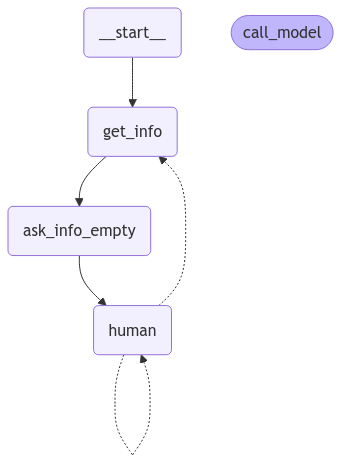

In [229]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [227]:
import uuid
from langchain_core.messages import AIMessage, HumanMessage, ToolMessage
config = {"configurable": {"thread_id": str(uuid.uuid4())}}
while True:
    user = input("User (q/Q to quit): ")
    print(f"User (q/Q to quit): {user}")
    if user in {"q", "Q"}:
        print("AI: Byebye")
        break
    output = None
    for output in graph.stream(
        {"messages": [HumanMessage(content=user)]}, config=config, stream_mode="updates"
    ):  
        print(output)
        # last_message = next(iter(output.values()))["messages"][-1]
        # last_message.pretty_print()

    if output and "prompt" in output:
        print("Done!")

User (q/Q to quit): hi
hi
{'messages': [HumanMessage(content='hi', additional_kwargs={}, response_metadata={}, id='862cc43f-9f71-483f-98f6-1d0b4c9ddfa0')]}
name='' number_phone='' pick_up_location='' destination_location='' pick_up_time=''
{'get_info': {'slot_empty': ['name', 'number_phone', 'pick_up_location', 'destination_location', 'pick_up_time'], 'booking_info': BookingCarDetails(name='', number_phone='', pick_up_location='', destination_location='', pick_up_time='')}}
{'ask_info_empty': {'messages': [{'role': 'ai', 'content': "I'm gathering some information to help you better. Can you please tell me your name?"}]}}
{'__interrupt__': (Interrupt(value='Ready for user input.', resumable=True, ns=['human:d25cbd4c-331c-fdf2-d07c-c8af4043260c'], when='during'),)}
User (q/Q to quit): q
AI: Byebye


In [202]:
import uuid

thread_config = {"configurable": {"thread_id": uuid.uuid4()}}

inputs = [
    # 1st round of conversation,
    {
        "messages": [
            {"role": "user", "content": "I want to book a car from 271 Nguyen Van Linh to 466 NGuyen van linh da nang at now"}
        ]
    },
    # Since we're using `interrupt`, we'll need to resume using the Command primitive.
    # 2nd round of conversation,
    Command(
        resume="name Huy."
    ),
    # 3rd round of conversation,
    Command(
        resume="0917181880"
    ),
]

for idx, user_input in enumerate(inputs):
    print()
    print(f"--- Conversation Turn {idx + 1} ---")
    print()
    print(f"User: {user_input}")
    print()
    for update in graph.stream(
        user_input,
        config=thread_config,
        stream_mode="updates",
    ):
        for node_id, value in update.items():
            if isinstance(value, dict) and value.get("messages", []):
                last_message = value["messages"][-1]
                if isinstance(last_message, dict) or last_message.type != "ai":
                    continue
                print(f"{node_id}: {last_message.content}")


--- Conversation Turn 1 ---

User: {'messages': [{'role': 'user', 'content': 'I want to book a car from 271 Nguyen Van Linh to 466 NGuyen van linh da nang at now'}]}

I want to book a car from 271 Nguyen Van Linh to 466 NGuyen van linh da nang at now
{'messages': [HumanMessage(content='I want to book a car from 271 Nguyen Van Linh to 466 NGuyen van linh da nang at now', additional_kwargs={}, response_metadata={}, id='47804117-8661-4799-b8e1-baee48f490ad')]}
booking_info is missing from state
state
{'messages': [HumanMessage(content='I want to book a car from 271 Nguyen Van Linh to 466 NGuyen van linh da nang at now', additional_kwargs={}, response_metadata={}, id='47804117-8661-4799-b8e1-baee48f490ad')], 'booking_info': BookingCarDetails(name='', number_phone='', pick_up_location='271 Đ. Nguyễn Văn Linh, Bình Thuận, Quận 7, Hồ Chí Minh, Vietnam', destination_location='466 Đ. Nguyễn Văn Linh, Thạc Gián, Thanh Khê, Đà Nẵng 550000, Vietnam', pick_up_time='now'), 'slot_empty': ['name', 'n

InvalidUpdateError: Must write to at least one of ['messages', 'quote_id', 'booking_info', 'slot_empty']